In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf, subplots, figure
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap, islice
import random
import time
from pprint import pprint
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average, as_wrapper, AverageExp
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point
from schlichtanders.mycontextmanagers import ignored

In [4]:
from theano_models import (Merge, Flatten, Reparameterize, Center, reduce_all_identities,
                           fix_params, inputting_references, outputting_references)
from theano_models.tools import (as_tensor_variable, total_size, clone, clone_all,PooledRandomStreams,
                                 get_profile, squareplus, squareplus_inv, softplus, softplus_inv)
from theano_models.visualization import d3viz
from IPython.display import IFrame
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
import theano_models.extra_models as em
import theano_models.postmaps as post
from theano_models.composing import normalizing_flow, variational_bayes

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
inputting_references.update(['to_be_randomized'])
inputting_references, outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'logP', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

# target

In [9]:
data_target = pm.Gauss(2, init_var=np.exp(-2))  # low variance, almost deterministic
data_target

Gauss { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fddc0dbcec0 for function at 0x7fddc0dc5398>,
  'outputs': GaussianNoise.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [10]:
param_target_base = pm.Gauss(2, init_mean=[0,0], init_var=2)
param_target_normflows = [dm.PlanarTransform(init__u=[3,6], init_w=[1,3], init_b=-1) for _ in range(1)]

param_target = param_target_base
for transform in param_target_normflows:
    param_target = normalizing_flow(transform, param_target)  # returns Merge
param_target

normalized_flow { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fddc0dbcfa0 for function at 0x7fddc0ddf578>,
  'norm_det': PlanarTransform.norm_det,
  'outputs': PlanarTransform.outputs,
  'parameters': [b, w, _u, mean2],
  'parameters_positive': [var2]}

In [11]:
data_target['parameters'] = param_target
target = Merge(data_target, param_target)

---

---

In [12]:
t_sampler = target.function()
n_samples = 10000
training = np.array([t_sampler() for _ in xrange(n_samples)])
targets = training

# model

In [ ]:
data_model = pm.Gauss(2, init_var=np.exp(-7))
data_model = Merge(data_model, parameters_positive=None)
data_model

In [ ]:
# param_model_base = pm.Gauss(2)
# param_model_base = Merge(param_model_base, parameters=None)
# param_model_normflows = [dm.PlanarTransform()]

param_model_base = fix_params(pm.Gauss(2))
param_model_normflows = [dm.PlanarTransform(), Merge(dm.LocScaleTransform(), parameters=None)]  # no mean to be adapted

param_model = param_model_base
for transform in param_model_normflows:
    param_model = normalizing_flow(transform, param_model)  # returns Merge
param_model

In [ ]:
prior = fix_params(pm.Gauss(2, init_var=np.exp(-6)))
# label hyper parameters accordingly
# prior = Merge(prior, parameters=None)
prior

In [ ]:
model = variational_bayes(data_model, 'parameters', param_model, priors=prior)
model

---

In [ ]:
model = pm.DiagGauss(2)

---

In [ ]:
data_model = Merge(pm.Gauss(2, init_var=np.exp(-3)), parameters_positive=None)
param_model = pm.DiagGauss(2)
# param_model = normalizing_flow(dm.LocScaleTransform(), fix_params(pm.DiagGauss(2)))
data_model['parameters'] = param_model
model = Merge(data_model, param_model)
model

---

In [13]:
model = target

----

In [14]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
_model = model
_model = Merge(_model, Reparameterize(_model['parameters_positive'], softplus, softplus_inv))
_model = Merge(_model, Center(_model['parameters']))
_model = Merge(_model, Flatten(_model['parameters']))
_model

Merge4 { 'flat': "b_centered:w_centered:_u_centered:mean2_centered:var_softplus_centered:var2_softplus_centered",
  'inputs': [],
  'logP': <FunctionWrapper at 0x7fddc0dbcec0 for function at 0x7fddc0dc5398>,
  'norm_det': PlanarTransform.norm_det,
  'outputs': GaussianNoise.outputs,
  'parameters': [],
  'parameters_positive': []}

# Visualization

In [15]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
example_samples = 1000
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:example_samples,0], targets[:example_samples,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(example_samples//2)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

In [56]:
values = np.linspace(-10, 10, 10)
Xvalues, Yvalues = np.meshgrid(values, values)
XY = np.c_[Xvalues.flat, Yvalues.flat]

logP = T.stack([model['logP'](as_tensor_variable(rv))['outputs'] for rv in XY])

f_logP = theano.function([_model['flat']], logP)

def plot_distr(fig):
    fig.clear()
#     Z = np.reshape(Average(1000)(f_logP, optimizer_kwargs['num_parameters']), Xvalues.shape)        
    Z = np.reshape(AverageExp(1000)(f_logP, optimizer_kwargs['num_parameters']), Xvalues.shape)        
    for i in range(2):
        ax = fig.add_subplot(1,2,i+1)
        if i==1:
            Z = np.exp(Z)
        h = ax.contourf(Xvalues, Yvalues, Z)
        plt.colorbar(h, ax=ax)
        fig.tight_layout()
        fig.canvas.draw()
# for i in range(20):

# optimizer

In [26]:
reduce_all_identities()

batch_size = 1
n_batches = len(targets) // batch_size  # after this many steps we went through the whole data set once

climin_args = izip(imap(lambda x:(x,), chunk(batch_size, cycle(training))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
assert len(list(weights_regularizer_1epoch())) == n_batches

In [27]:
postmap = compose(post.flat_numericalize_postmap, post.probabilistic_optimizer_postmap) 
postmap_kwargs = {
    'pre_compile':{'num_loss': False, 'num_jacobian': False, 'num_hessian': False},
    'mapreduce': meanmap,  # TODO add more functionality for composed fmaps, with args
    'wrapper': as_wrapper(AverageExp(40)),
#     'annealing_combiner': post.AnnealingCombiner(
#         weights_regularizer=cycle(weights_regularizer_1epoch())
#     ),
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size, scale=1),
#     'profile': True,
#     'mode': 'FAST_COMPILE'
}
optimizer_kwargs = postmap(_model, **postmap_kwargs)

In [28]:
opt = optimizer(
#     identifier='adam',
    identifier="rmsprop",
    step_rate=1e-3,
    momentum=0.9, #0.9,
    args=climin_args,
    **post.climin_postmap(optimizer_kwargs)
)

<IPython.core.display.Javascript object>


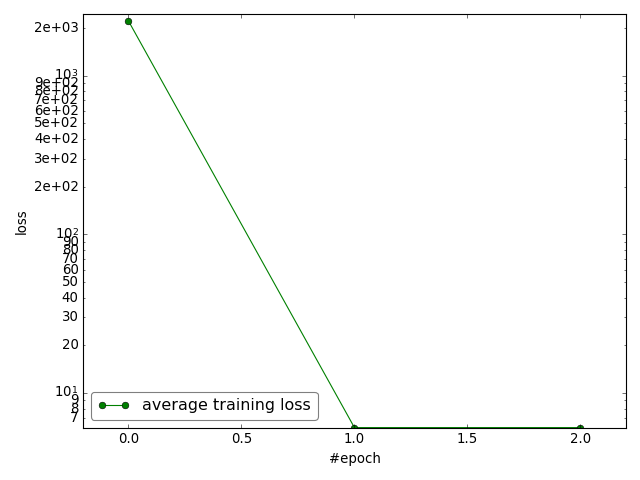

In [29]:
figure()
# plot:
line_train, = plot([], [], 'go-', label="average training loss")
# line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
# line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

# start values:
best_parameters = optimizer_kwargs['num_parameters']
# best_val_loss = optimizer_kwargs['num_loss'](best_parameters, validation, no_annealing=True)
# best_val_loss /= len(validation)
training_loss = optimizer_kwargs['num_loss'](best_parameters, targets)#, no_annealing=True)
# training_loss /= len(targets)
last_improvement_epoch = opt.n_iter//n_batches

# add_point(line_best_val, last_improvement_epoch, best_val_loss)
# add_point(line_curr_val, last_improvement_epoch, best_val_loss)
add_point(line_train, last_improvement_epoch, training_loss)

<IPython.core.display.Javascript object>


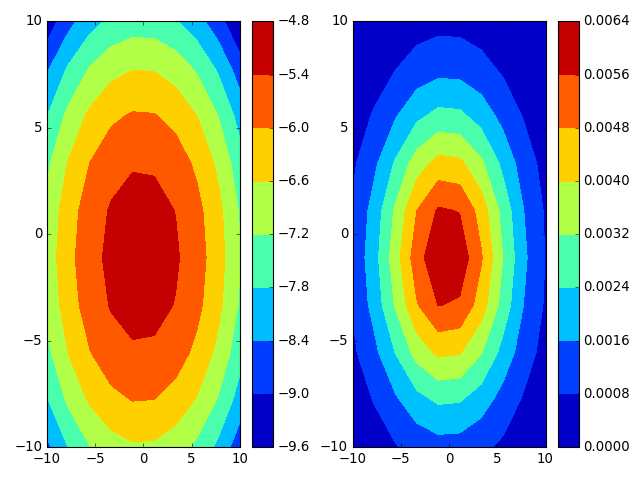

In [57]:
figdistr = figure()
plot_distr(figdistr)

<IPython.core.display.Javascript object>


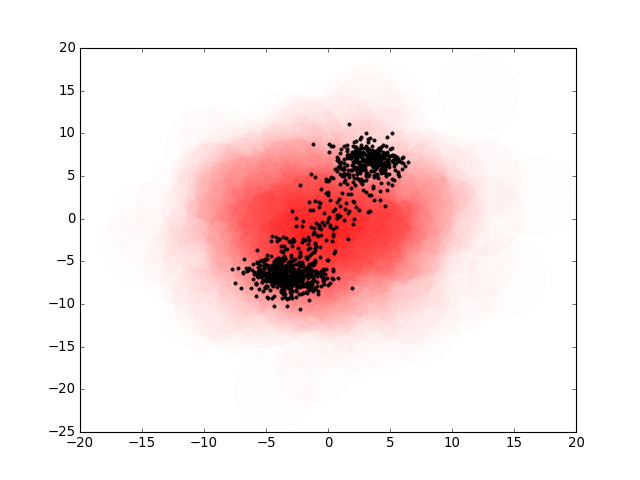

In [22]:
fig, ax = subplots()
plot_fit(fig, ax, {_model['flat']:optimizer_kwargs['num_parameters']})

In [58]:
human_readable_parameters = model['parameters'] + model['parameters_positive']
f = theano.function([_model['flat']], human_readable_parameters)
old_num_params = f(opt.wrt)
        
with ignored(KeyboardInterrupt):
    for info in every(n_batches, opt):  #every(n_batches, opt):
        current_epoch = info['n_iter']//n_batches
        # visualize training loss for comparison:
        training_loss = optimizer_kwargs['num_loss'](opt.wrt, targets)#, no_annealing=True)
#         training_loss /= len(targets)
        add_point(line_train, current_epoch, training_loss)
        
        
        num_params = f(opt.wrt)
        print "jacobiannames", str(_model['flat'])
        print "jacobian", optimizer_kwargs['num_jacobian'](opt.wrt, targets[:batch_size])
        diff_params = [n - o for n, o in izip(num_params, old_num_params)]
        print("params")
        pprint(dict(zip(map(str, human_readable_parameters), num_params)))
        print("diff")
        pprint(dict(zip(map(str, human_readable_parameters), diff_params)))
        print
        
        plot_distr(figdistr)
        plot_fit(fig, ax, {_model['flat']:opt.wrt}, time_delay=None)
        old_num_params = num_params

jacobiannames "b_centered:w_centered:_u_centered:mean2_centered:var_softplus_centered:var2_softplus_centered"
jacobian [  4.09656850e-02  -6.37804540e-03  -4.66186846e-02   6.63358902e-03
  -3.43234487e-03  -4.93091767e-03   2.82068619e-02   3.18201690e-02
   3.35676371e-05]
params
{'_u_centered': array([ 0.97322189,  2.11469572]),
 'b_centered': array(-2.694687069599762),
 'mean2_centered': array([-0.21510156, -0.87495657]),
 'var2_reparam': array(5.725698636983106e-05),
 'var_reparam': array(25.0222284831225),
 'w_centered': array([-1.11201629, -2.26490711])}
diff
{'_u_centered': array([-2.16758418, -3.23379988]),
 'b_centered': -2.6232220788131198,
 'mean2_centered': array([-0.78026361, -1.03939378]),
 'var2_reparam': -2.9136001423342486,
 'var_reparam': 24.960357097509423,
 'w_centered': array([-1.99580803, -4.14288557])}

jacobiannames "b_centered:w_centered:_u_centered:mean2_centered:var_softplus_centered:var2_softplus_centered"
jacobian [  3.28085907e-02  -1.16275032e-02  -3.798

In [ ]:
%debug

---

In [ ]:
best_parameters = None
best_val_loss = inf
last_improvement_epoch = 1
for info in every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    if current_epoch - last_improvement_epoch > 50:
        break
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, training, no_annealing=True)
    if val_loss < best_val_loss:
        last_improvement_epoch = current_epoch
        best_parameters = opt.wrt
        best_val_loss = val_loss
    
    print zip(model['flat'].name.split(':'), climin_kwargs['fprime'](opt.wrt, training[:100], no_annealing=True))
    plot_fit(fig, ax, givens={model['flat']: opt.wrt}, time_delay=None)
    print best_val_loss,

In [ ]:
%debug

In [ ]:
optimizer_kwargs['flat']

In [ ]:
%timeit optimizer_kwargs['num_jacobian'](best_parameters, targets[:100])

In [ ]:
stats = np.array([optimizer_kwargs['num_jacobian'](best_parameters, targets[:100]) for _ in range(1000)])

In [ ]:
stats[:100]

In [ ]:
plot(stats.T)
pass

In [ ]:
stats.mean(0)

In [ ]:
stats.var(0)

In [ ]:
opt.n_iter

In [ ]:
model.u.eval({model['flat']: best_parameters})

In [ ]:
theano.function([model['flat']], 
                [model.b, target.b,
                 model.w, target.w,
                 model._u, target._u, 
                 param_model_base.mean, 
                 param_target_base.mean, 
                 param_model_base.var, param_target_base.var,
                 data_model.var],
                mode="FAST_COMPILE")(best_parameters)

In [ ]:
best_val_loss

Using the default scipy optimizer, one can see very good, that the problem is ill-defined in that the maximum likelihood solution is a ill-formed solution.